In [40]:
import pandas as pd
import numpy as np

In [41]:
AGG = pd.read_excel('/Users/charlesxiong/Desktop/IBKR_algo/ode/data/BBG AGG BOND/BBG AGG BOND_positions.xlsx')
SPX = pd.read_excel('/Users/charlesxiong/Desktop/IBKR_algo/ode/data/SPX/SPX_positions.xlsx')
USD = pd.read_excel('/Users/charlesxiong/Desktop/IBKR_algo/ode/data/USD/USD_positions.xlsx')
GLD = pd.read_excel('/Users/charlesxiong/Desktop/IBKR_algo/ode/data/GLD.xlsx')

In [42]:
AGG

,Unnamed: 0,DateTime,BBG AGG BOND_Position,BBG AGG BOND_Return
0,0,2008-01-02,NaN,NaN
1,1,2008-01-03,1.0,-0.000093
2,2,2008-01-04,1.0,0.002747
3,3,2008-01-07,1.0,0.001241
4,4,2008-01-08,1.0,-0.000387
...,...,...,...,...
4314,4314,2025-03-03,0.0,0.002339
4315,4315,2025-03-04,0.0,-0.002728
4316,4316,2025-03-05,0.0,-0.003710
4317,4317,2025-03-06,0.0,-0.000513


In [43]:
GLD['GLD_Return'] = GLD['GLD_Close'].pct_change()
GLD['GLD_Position'] = 1

In [44]:
SPX.columns

Index(['Unnamed: 0', 'DateTime', 'SPX_Position', 'SPX_Return'], dtype='object')

In [45]:
USD.columns

Index(['Unnamed: 0', 'DateTime', 'USD_Position', 'USD_Return'], dtype='object')

In [46]:
df = pd.merge(AGG[['DateTime' ,'BBG AGG BOND_Position','BBG AGG BOND_Return']],
        SPX[['DateTime', 'SPX_Position', 'SPX_Return']], on='DateTime', how='inner')

df = pd.merge(df, USD[['DateTime', 'USD_Position', 'USD_Return']], on='DateTime', how='inner')
df = pd.merge(df, GLD[['DateTime', 'GLD_Position', 'GLD_Return']], on='DateTime', how='inner')
df

,DateTime,BBG AGG BOND_Position,BBG AGG BOND_Return,SPX_Position,SPX_Return,USD_Position,USD_Return,GLD_Position,GLD_Return
0,2008-01-02,NaN,NaN,0.0,-0.014438,0.0,-0.009518,1,-0.008297
1,2008-01-03,1.0,-0.000093,0.0,0.000000,0.0,-0.001053,1,0.005169
2,2008-01-04,1.0,0.002747,0.0,-0.024552,0.0,-0.001318,1,0.004247
3,2008-01-07,1.0,0.001241,0.0,0.003223,0.0,0.005014,1,-0.023162
4,2008-01-08,1.0,-0.000387,0.0,-0.018352,1.0,-0.000788,1,0.002657
...,...,...,...,...,...,...,...,...,...
4288,2025-03-03,0.0,0.002339,0.0,-0.003294,1.0,-0.007992,1,-0.008623
4289,2025-03-04,0.0,-0.002728,0.0,-0.012235,0.0,-0.009461,1,-0.002077
4290,2025-03-05,0.0,-0.003710,0.0,0.011159,0.0,0.000000,1,0.005107
4291,2025-03-06,0.0,-0.000513,0.0,-0.017819,0.0,-0.015888,1,-0.000522


In [47]:
import matplotlib.pyplot as plt

# 假设 df 是你传的 DataFrame
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Step 1: Calculate each asset's cumulative return
df['SPX_CumRet'] = (1 + df['SPX_Return'].fillna(0)).cumprod()
df['BOND_CumRet'] = (1 + df['BBG AGG BOND_Return'].fillna(0)).cumprod()
df['USD_CumRet'] = (1 + df['USD_Return'].fillna(0)).cumprod()

# Step 2: Calculate daily portfolio return
position_cols = ['SPX_Position', 'BBG AGG BOND_Position', 'USD_Position']
return_cols = ['SPX_Return', 'BBG AGG BOND_Return', 'USD_Return']

# 计算每天持有的资产数量
df['Active_Assets'] = df[position_cols].sum(axis=1).replace(0, pd.NA)

# 如果当日没有任何资产被持有（position都为0），返回为0
df['Portfolio_Return'] = df.apply(
    lambda row: sum(
        row[pos] * row[ret] for pos, ret in zip(position_cols, return_cols)
    ) / row['Active_Assets'] if pd.notna(row['Active_Assets']) else 0,
    axis=1
)

# Step 3: Calculate cumulative return of portfolio
df['Portfolio_CumRet'] = (1 + df['Portfolio_Return'].fillna(0)).cumprod()

In [48]:
def sharpe_ratio(series, annualization=252):
    excess_ret = series.fillna(0)
    return (excess_ret.mean() / excess_ret.std()) * (annualization**0.5)

spx_sr = sharpe_ratio(df['SPX_Return'])
bond_sr = sharpe_ratio(df['BBG AGG BOND_Return'])
usd_sr = sharpe_ratio(df['USD_Return'])
port_sr = sharpe_ratio(df['Portfolio_Return'])


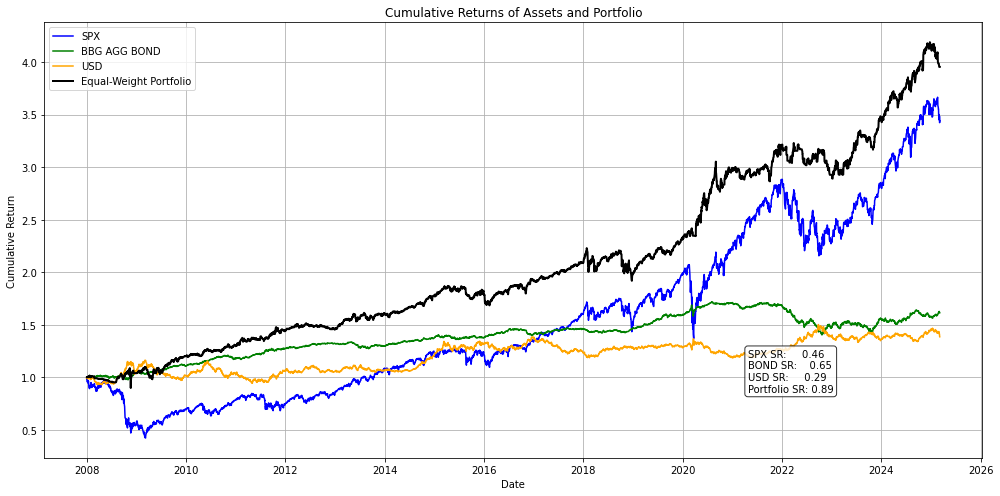

In [49]:
plt.figure(figsize=(14, 7))
plt.plot(df['DateTime'].values, df['SPX_CumRet'].values, label='SPX', color='blue')
plt.plot(df['DateTime'].values, df['BOND_CumRet'].values, label='BBG AGG BOND', color='green')
plt.plot(df['DateTime'].values, df['USD_CumRet'].values, label='USD', color='orange')
plt.plot(df['DateTime'].values, df['Portfolio_CumRet'].values, label='Equal-Weight Portfolio', color='black', linewidth=2)

# 📌 Add Sharpe Ratio box
textstr = '\n'.join((
    f'SPX SR:     {spx_sr:.2f}',
    f'BOND SR:    {bond_sr:.2f}',
    f'USD SR:     {usd_sr:.2f}',
    f'Portfolio SR: {port_sr:.2f}'
))

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.75, 0.25, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.title('Cumulative Returns of Assets and Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


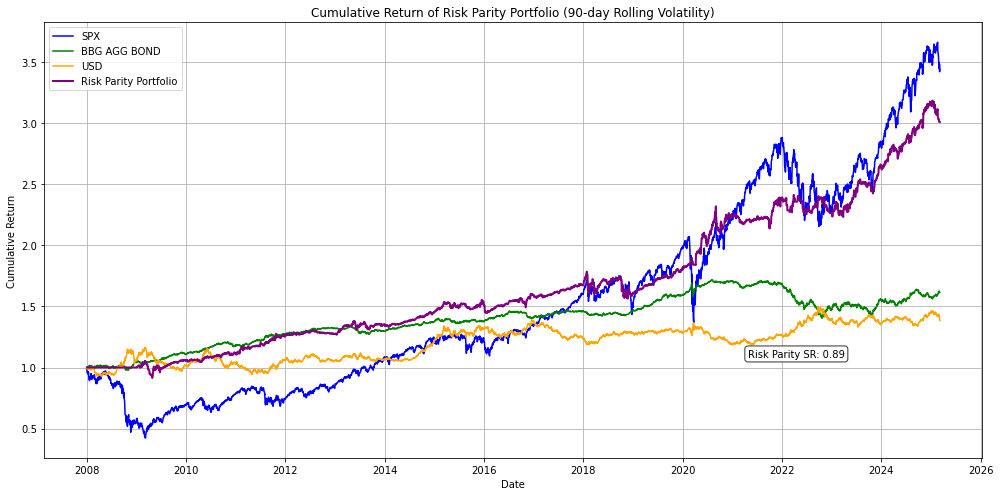

In [50]:
# Step 2: 90-day rolling volatility
vol_window = 252
df['SPX_Vol'] = df['SPX_Return'].rolling(vol_window).std()
df['BOND_Vol'] = df['BBG AGG BOND_Return'].rolling(vol_window).std()
df['USD_Vol'] = df['USD_Return'].rolling(vol_window).std()

# Step 3: Inverse vol weights
inv_vol = 1 / df[['SPX_Vol', 'BOND_Vol', 'USD_Vol']]
inv_vol_sum = inv_vol.sum(axis=1)
df['w_SPX'] = (inv_vol['SPX_Vol'] / inv_vol_sum) * df['SPX_Position']
df['w_BOND'] = (inv_vol['BOND_Vol'] / inv_vol_sum) * df['BBG AGG BOND_Position']
df['w_USD'] = (inv_vol['USD_Vol'] / inv_vol_sum) * df['USD_Position']

# Re-normalize weights if some assets are not active
weight_total = df[['w_SPX', 'w_BOND', 'w_USD']].sum(axis=1).replace(0, np.nan)
df['w_SPX'] /= weight_total
df['w_BOND'] /= weight_total
df['w_USD'] /= weight_total

# Step 4: Calculate Risk Parity Portfolio Return
df['RP_Return'] = (
    df['w_SPX'] * df['SPX_Return'] +
    df['w_BOND'] * df['BBG AGG BOND_Return'] +
    df['w_USD'] * df['USD_Return']
)

# Step 5: Cumulative Return
df['RP_CumRet'] = (1 + df['RP_Return'].fillna(0)).cumprod()

# Step 6: Sharpe Ratio
def sharpe_ratio(series, annualization=252):
    excess_ret = series.fillna(0)
    return (excess_ret.mean() / excess_ret.std()) * (annualization**0.5)

rp_sr = sharpe_ratio(df['RP_Return'])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['DateTime'].values, df['SPX_CumRet'].values, label='SPX', color='blue')
plt.plot(df['DateTime'].values, df['BOND_CumRet'].values, label='BBG AGG BOND', color='green')
plt.plot(df['DateTime'].values, df['USD_CumRet'].values, label='USD', color='orange')
plt.plot(df['DateTime'].values, df['RP_CumRet'].values, label='Risk Parity Portfolio', color='purple', linewidth=2)

# SR box
textstr = f'Risk Parity SR: {rp_sr:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.75, 0.25, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.title('Cumulative Return of Risk Parity Portfolio (90-day Rolling Volatility)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

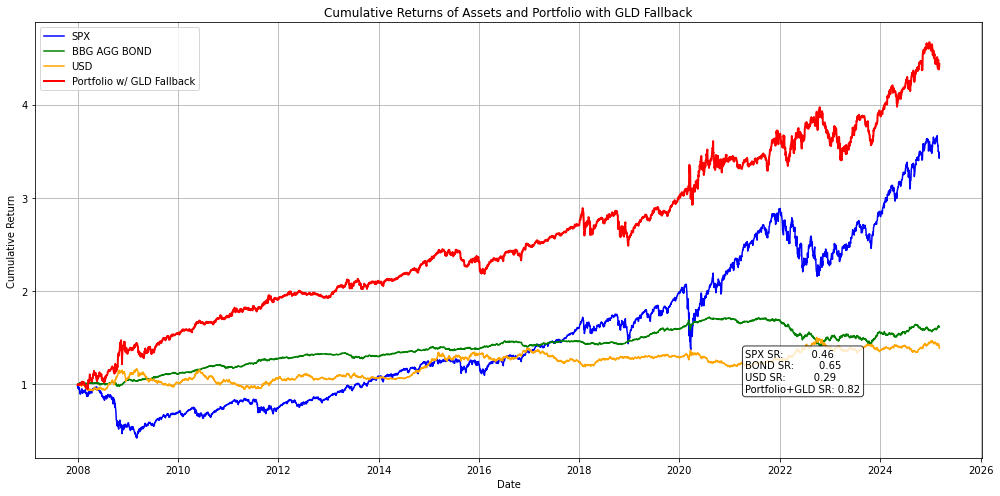

In [51]:
# Continue from previous setup: introduce GLD fallback asset

# Assume GLD_Position is always 1 in this fallback setup
df["GLD_Position"] = 1  # always available as a fallback
df["GLD_CumRet"] = (1 + df["GLD_Return"].fillna(0)).cumprod()

# Modified Portfolio Return: fallback to GLD if all three other positions are 0
df["Portfolio_Return_GLDfallback"] = df.apply(
    lambda row: (
        sum(row[pos] * row[ret] for pos, ret in zip(position_cols, return_cols)) / row["Active_Assets"]
        if pd.notna(row["Active_Assets"])
        else row["GLD_Return"]
    ),
    axis=1
)

# Cumulative Return for new strategy
df["Portfolio_CumRet_GLDfallback"] = (1 + df["Portfolio_Return_GLDfallback"].fillna(0)).cumprod()

# Sharpe Ratio for fallback portfolio
port_sr_gld = sharpe_ratio(df["Portfolio_Return_GLDfallback"])

# Plotting with GLD fallback included
plt.figure(figsize=(14, 7))
plt.plot(df['DateTime'].values, df['SPX_CumRet'].values, label='SPX', color='blue')
plt.plot(df['DateTime'].values, df['BOND_CumRet'].values, label='BBG AGG BOND', color='green')
plt.plot(df['DateTime'].values, df['USD_CumRet'].values, label='USD', color='orange')
# plt.plot(df['DateTime'].values, df['Portfolio_CumRet'].values, label='Equal-Weight Portfolio', color='black', linewidth=2)
plt.plot(df['DateTime'].values, df['Portfolio_CumRet_GLDfallback'].values, label='Portfolio w/ GLD Fallback', color='red', linewidth=2)

# 📌 Add updated Sharpe Ratio box
textstr = '\n'.join((
    f'SPX SR:         {spx_sr:.2f}',
    f'BOND SR:        {bond_sr:.2f}',
    f'USD SR:         {usd_sr:.2f}',
#     f'Portfolio SR:   {port_sr:.2f}',
    f'Portfolio+GLD SR: {port_sr_gld:.2f}'
))

props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.75, 0.25, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.title('Cumulative Returns of Assets and Portfolio with GLD Fallback')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
